1.1980795860290527


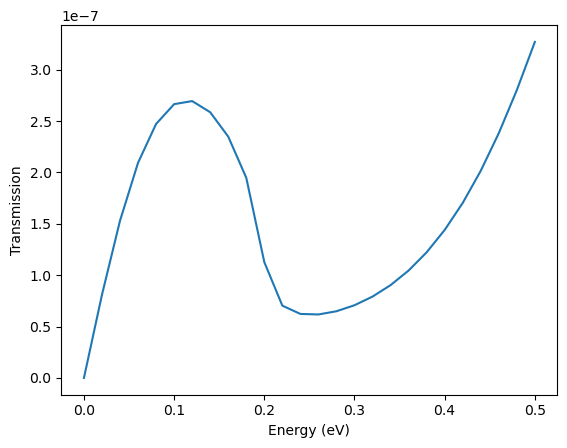

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

t1= time.time()
# Constants (all MKS, except energy which is in eV)
hbar = 1.06e-34
q = 1.6e-19
m = 0.25 * 9.1e-31
IE = (q*q) / (2 * np.pi * hbar)
Ef = 0.1
kT = 0.025

# Inputs
a = 3e-10
t0 = (hbar**2) / (2 * m * (a**2) * q)
NS = 15
NC = 16
ND = 15
Np = NS + NC + ND

# Hamiltonian matrix
UB = np.concatenate((np.zeros(NS), np.array([0.4]*4), np.zeros(NC-8), np.array([0.4]*4), np.zeros(ND)))
T = (2 * t0 * np.diag(np.ones(Np))) - (t0 * np.diag(np.ones(Np-1), k=1)) - (t0 * np.diag(np.ones(Np-1), k=-1))
T = T + np.diag(UB)

# Bias
V_range = np.linspace(0, 0.5, 26) # Range of bias voltages to calculate
I_array = [] # Array to store the currents for each bias voltage

j =0;
for V in V_range:
    mu1 = Ef + (V/2)
    mu2 = Ef - (V/2)
    U1 = V * np.concatenate((0.5 * np.ones(NS), np.linspace(0.5, -0.5, NC), -0.5 * np.ones(ND)))

    # Energy grid for Green's function method
    NE = 101
    E = np.linspace(-0.2, 0.8, NE)
    zplus = 1j * 1e-12
    dE = E[1] - E[0]
    f1 = 1 / (1 + np.exp((E - mu1) / kT))
    f2 = 1 / (1 + np.exp((E - mu2) / kT))

    # Transmission
    I = 0  # Current
    TM = np.zeros(NE)

    for k in range(NE):
        sig1 = np.zeros((Np, Np), dtype=complex)
        sig2 = np.zeros((Np, Np), dtype=complex)
        sig3 = np.zeros((Np, Np), dtype=complex)
        ck = 1 - ((E[k] + zplus - U1[0] - UB[0]) / (2 * t0))
        ka = np.arccos(ck)
        sig1[0, 0] = -t0 * np.exp(1j*ka)
        gam1 = 1j * (sig1 - np.conj(sig1.T))
        ck = 1 - ((E[k] + zplus - U1[Np-1] - UB[Np-1]) / (2 * t0))
        ka = np.arccos(ck)
        sig2[Np-1, Np-1] = -t0 * np.exp(1j*ka)
        gam2 = 1j * (sig2 - np.conj(sig2.T))
        G = ((E[k] + zplus) * np.eye(Np)) - T - np.diag(U1) - sig1 - sig2 - sig3
        TM[k] = np.real(np.trace(np.dot(np.dot(gam1, np.linalg.inv(G)), np.dot(gam2,np.conj((np.linalg.inv(G)).T)))))
        I = I + (dE * IE * TM[k] * (f1[k] - f2[k]))
    I_array.append(I)

t2 = time.time()

print(t2-t1);
# Plot transmission vs energy
plt.plot(V_range, I_array)
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission')
plt.show()
